In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import seaborn as sns
from scipy.stats import norm
%matplotlib notebook
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import matplotlib.patches as patches
from datetime import datetime
import time

In [286]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

## Create a hitmap that is 20*20

In [287]:
def get_gaussian_weights(value, stds):
    
    '''
    return the weights for the time, longitude, and latitude for interpolation
    Uses the Gaussian distribution 
    
    param: values = list with [longitude, latitude, time] of that point
    param: stds = list with custom stds for [time, lon, lat]
    '''
    
    lon, lat, time = tuple(value)
    lon_std, lat_std, time_std = tuple(stds)
    
    z_lon = (df['Lon'] - lon) / lon_std
    z_lat = (df['Lat'] - lat) / lat_std
    z_time = (df['secDay'] - time) / time_std
    
    # finds the weights
    w_lon = norm.pdf(z_lon)
    w_lat = norm.pdf(z_lat)
    w_time = norm.pdf(z_time)
    
    return w_lon, w_lat, w_time

In [288]:
def get_data_for_heatmap(lons, lats, time, dists, heatmap_size, col_name='sw pCO2 (uatm)', time_factor=1, size_factor=1):
    
    dist_lon, dist_lat, dist_time = tuple(dists) 
    stds=[dist_lon * size_factor, dist_lat * size_factor, dist_time * time_factor]

    data = np.zeros((heatmap_size, heatmap_size))
    for i, lat in enumerate(lats):
        
        data_arr = []
        
        for lon in lons:
            w_lon, w_lat, w_time = get_gaussian_weights((lon, lat, time), stds=stds)
            
            X = df[col_name].values
            val = np.sum(X * w_time * w_lon * w_lat) / np.sum(w_time * w_lon * w_lat)            
            data_arr.append(val)
        
        data[i, :] = data_arr
        
    return data

# Displaying timeseries heatmap

In [289]:
def get_boundary_box(corners, R=6378137):
    '''
    Corners follow the order NW, NE, SE, SW, (longitude, latitude)
    
    returns: upperbound, lower bound, right bound, left bound
    '''
    northmost = max(corners, key=lambda x: x[0])
    southmost = min(corners, key=lambda x: x[0])
    eastmost = max(corners, key=lambda x: x[1])
    westmost = min(corners, key=lambda x: x[1])  
    
    def get_coords_from_offsets(dn, de, coord):
        
        lon, lat = coord
        
        #Coordinate offsets in radians
        dLat = dn/R
        dLon = de/(R*np.cos(np.pi*lat/180))

        #//OffsetPosition, decimal degrees
        latO = lat + dLat * 180/np.pi
        lonO = lon + dLon * 180/np.pi 
        return (lonO, latO)
    
    # offsets in meters for north
    dn = 300
    de = 0
    
    _, north_lat = get_coords_from_offsets(dn, de, northmost)
    
    # offsets in meters for south
    dn = -300
    de = 0
    
    _, south_lat = get_coords_from_offsets(dn, de, southmost)
    
    # offsets in meters for east
    dn = 0
    de = 300
    
    east_lon, _ = get_coords_from_offsets(dn, de, eastmost)
    
    # offsets in meters for east
    dn = 0
    de = -300
    
    west_lon, _ = get_coords_from_offsets(dn, de, westmost)
    
#     corners = [(west_lon, north_lat), (east_lon, north_lat), (west_lon, south_lat), (east_lon, south_lat)]
    
    return [north_lat, south_lat, east_lon, west_lon]

In [290]:
df = pd.read_csv('FLO_L3_20170502.csv', skiprows=[1])

# filters out all the values that are -9999
df.replace(-9999, np.NaN, inplace=True)
df = df[['Lat', 'Lon', 'secDay', 'Water temp (C)', 'Salinity (PSU)', 'O2 umol/L', 'Chl a (mg/m3)', 'sw pCO2 (uatm)']]
df.dropna(inplace=True)


# filter out noisy data
df = df[(df['sw pCO2 (uatm)'] > 100) & (df['sw pCO2 (uatm)'] < 600)]

# converts secDay to AM PM Time
# Also adds date
df['time (GMT)'] = df['secDay'].apply(lambda x: '2017-05-02 ' + time.strftime('%I:%M:%S %p', time.localtime(x)))

heatmap_size = 30
time_size = 12

# to change the standard deviations
size_factor = 2
time_factor = 2

# calculates the distance of each box of the heatmap in lat/lon units
dist_lon = (df['Lon'].max() - df['Lon'].min()) / heatmap_size
dist_lat = (df['Lat'].max() - df['Lat'].min()) / heatmap_size
dist_time = (df['secDay'].max() - df['secDay'].min()) / time_size

# gets the values to interpolate from (which is the lat,lon coordinate in the middle of each box in the heatmap)
lons = np.linspace(df['Lon'].min(), df['Lon'].max(), heatmap_size * 2, endpoint=False)[1::2]
lats = np.linspace(df['Lat'].min(), df['Lat'].max(), heatmap_size * 2, endpoint=False)[1::2]
times = np.linspace(df['secDay'].min(), df['secDay'].max(), time_size * 2, endpoint=False)[1::2]



In [291]:
# sets bounds for longitude
NW = (-70.14655, 43.72273)
NE = (-70.14619, 43.72253)
SE = (-70.14876, 43.72015)
SW = (-70.14911, 43.72035)
corners = [NW, NE, SE, SW]

In [292]:
# bounds the graph within 300 meters of the farm
boundary = get_boundary_box(corners)

df = df[(df['Lat'] < boundary[0]) & 
        (df['Lat'] > boundary[1]) & 
        (df['Lon'] < boundary[2]) & 
        (df['Lon'] > boundary[3])]

In [293]:

# for colormap purposes
vmin = df['sw pCO2 (uatm)'].min()
vmax = df['sw pCO2 (uatm)'].max()

In [294]:
kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e2)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=1e2, 
                                   length_scale_bounds=(1e-4, 1e5), alpha_bounds=(1e-5, 1e5)),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(1e-3, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(1.0, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-3, 10.0),
                        nu=1.5)]

In [295]:
# X = df[['Lon', 'Lat']].values
# y = df['sw pCO2 (uatm)'].values
# log_likelihoods = []
# for k in kernels:
#     gpr = GaussianProcessRegressor(kernel=k, n_restarts_optimizer=5)
#     gpr.fit(X, y)
#     likelihood = gpr.log_marginal_likelihood(gpr.kernel_.theta)
#     log_likelihoods.append(likelihood)

In [296]:
kernel = kernels[1]

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=1e-5, normalize_y=True)
# gpr = GaussianProcessRegressor()

In [297]:
X = df[['Lon', 'Lat']].values
y = df['sw pCO2 (uatm)'].values

In [298]:
# standardizing data
X = (X - X.mean(0)) / X.std(0)

In [299]:
gpr.fit(X, y)

GaussianProcessRegressor(alpha=1e-05, copy_X_train=True,
             kernel=1**2 * RationalQuadratic(alpha=100, length_scale=1),
             n_restarts_optimizer=5, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [300]:
print ("Posterior (kernel: %s)\n Log-Likelihood: %.3f" % (gpr.kernel_, gpr.log_marginal_likelihood(gpr.kernel_.theta)))

Posterior (kernel: 28.6**2 * RationalQuadratic(alpha=0.00646, length_scale=0.0648))
 Log-Likelihood: -1367.070


<IPython.core.display.Javascript object>


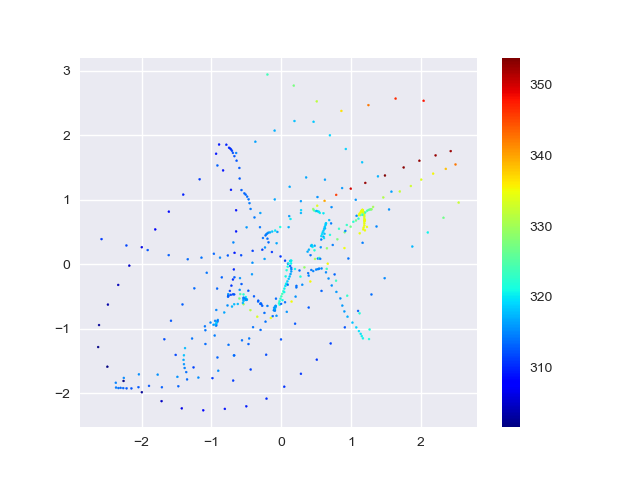

In [301]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=2, c=gpr.predict(X), cmap='jet')
plt.colorbar()
plt.gca().add_patch(patches.Polygon(xy=corners, fill=False, edgecolor='r'))

In [302]:
# xy = np.mgrid[df['Lon'].min():df['Lon'].max():30j, df['Lat'].min():df['Lat'].max():30j].reshape(2,-1).T
x = np.linspace(df['Lon'].min(), df['Lon'].max(), heatmap_size)
y = np.linspace(df['Lat'].min(), df['Lat'].max(), heatmap_size)
x, y = np.meshgrid(x, y)
xy = np.array([thing for thing in zip(x.flatten(), y.flatten())]) 

In [303]:
# normalize xy
xy = (xy - xy.mean(0)) / xy.std(0)

In [304]:
# since xy change longitude first than latitutde, the result will need an column-first reordering
data_arr, sigmas = gpr.predict(xy, return_std=True)
data_arr = data_arr.reshape(heatmap_size, heatmap_size)

In [305]:
sigmas.shape

(900,)

<IPython.core.display.Javascript object>


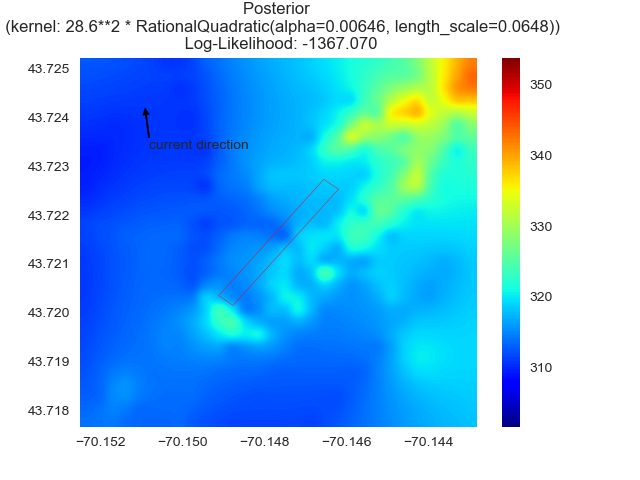

In [306]:
extent = [boundary[3], boundary[2], boundary[1], boundary[0]]

fig, ax = plt.subplots()
im = ax.imshow(data_arr, cmap='jet', origin='lower', interpolation='gaussian', 
               extent=extent, aspect='auto', vmin=vmin, vmax=vmax)
ax.grid(False)

direction = np.deg2rad(354)
r = 30
center = (50, 200)
new_center = (r * np.sin(direction) + center[0], r * np.cos(direction) + center[1]) 

ax.annotate('current direction', xy=new_center, xytext=center, xycoords='axes points',
            arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5))

# adds the location of the farm
ax.add_patch(patches.Polygon(xy=corners, fill=False, edgecolor='r'))
ax.set_title("Posterior \n: (kernel: %s)\n Log-Likelihood: %.3f" % (gpr.kernel_, gpr.log_marginal_likelihood(gpr.kernel_.theta)))
fig.colorbar(im)

In [307]:
# extent = [boundary[3], boundary[2], boundary[1], boundary[0]]

# fig, ax = plt.subplots()
# im = ax.imshow(sigmas.reshape(heatmap_size, heatmap_size), cmap='jet', origin='lower', interpolation='gaussian', 
#                extent=extent, aspect='auto')
# ax.grid(False)

# # adds the location of the farm
# ax.add_patch(patches.Polygon(xy=corners, fill=False, edgecolor='r'))
# # ax.set_title("Posterior \n: (kernel: %s)\n Log-Likelihood: %.3f" % (gpr.kernel_, gpr.log_marginal_likelihood(gpr.kernel_.theta)))
# fig.colorbar(im)

## Sliding window with Flow data

In [308]:
tides_df = pd.read_csv('Tidal_Current Data/CAB1409_prediction_Timeseries_2017-05-02_cleaned.csv')

# # adds seconds
# tides_df['Date_Time (GMT)'] = tides_df['Date_Time (GMT)'].apply(lambda x: x[:-3] + ':00' + x[-3:])
# tides_df['direction'] = np.where(tides_df['Speed (cm/sec)'])

In [309]:
tides_df.head()

,Date_Time (GMT),Speed (cm/sec),Direction (degrees relative to North)
0,2017-05-02 12:00:00 AM,-20.8,179
1,2017-05-02 12:06:00 AM,-18.9,179
2,2017-05-02 12:12:00 AM,-17.1,179
3,2017-05-02 12:18:00 AM,-15.4,179
4,2017-05-02 12:24:00 AM,-13.7,179


In [310]:

# kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e4))
kernel = kernels[1]
gp = GaussianProcessRegressor(kernel=kernel)

In [311]:
X = np.array([int(datetime.strptime(x, '%Y-%m-%d %I:%M:%S %p').strftime('%s')) 
              for x in tides_df['Date_Time (GMT)']])
X = X - X.min() # subtracts the min
y = tides_df['Speed (cm/sec)'].values
X_pred = df['secDay'].values
y_pred = np.interp(X_pred, X, y)

In [230]:
# print ("Posterior (kernel: %s)\n Log-Likelihood: %.3f" % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)))

In [231]:
# y_pred.mean()

<IPython.core.display.Javascript object>


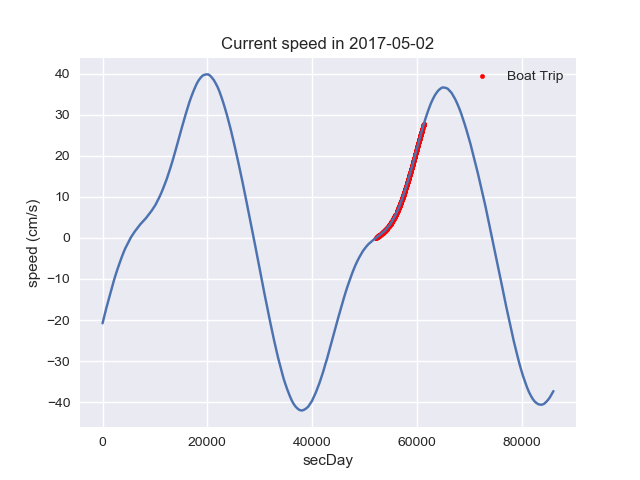

In [315]:
plt.figure()
plt.plot(X, y)
plt.scatter(X_pred, y_pred, c='r', s=10, label='Boat Trip')
plt.xlabel('secDay')
plt.ylabel('speed (cm/s)')
plt.title('Current speed in 2017-05-02')
plt.legend()

In [265]:
time_size = 4
df['secDay_label'] =  pd.cut(df['secDay'], bins=time_size, labels=False)

<IPython.core.display.Javascript object>


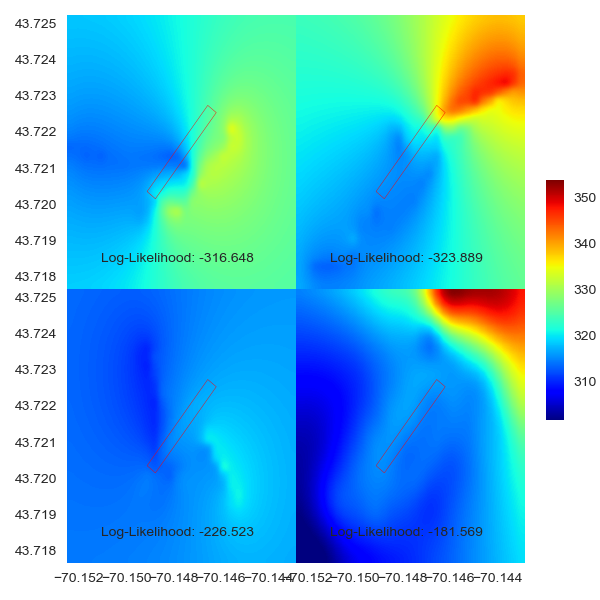

/Users/Mike/anaconda/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 5, 'warnflag': 2, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  2.06567245e-01,   1.69698254e-02,   4.33869324e+02]), 'funcalls': 54}
  " state: %s" % convergence_dict)
/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [283]:
fig, axes = plt.subplots(2,2, figsize=(6,6), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
# extent = [df['Lon'].min(), df['Lon'].max(), df['Lat'].min(), df['Lat'].max()]
extent = [boundary[3], boundary[2], boundary[1], boundary[0]]
# plt.subplots_adjust(wspace=0, hspace=0)
for i, ax in enumerate(axes.flat):
    
    # uses kriging for prediction
    kernel = 1.0 * RationalQuadratic(length_scale=1.0, alpha=1e2, 
                                     length_scale_bounds=(1e-4, 1e5), alpha_bounds=(1e-5, 1e5))
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=1e-5, normalize_y=True)
    
    X = df[df['secDay_label'] == i][['Lon', 'Lat']].values
    y = df[df['secDay_label'] == i]['sw pCO2 (uatm)'].values
    
    gpr.fit(X, y)

    x = np.linspace(df['Lon'].min(), df['Lon'].max(), heatmap_size)
    y = np.linspace(df['Lat'].min(), df['Lat'].max(), heatmap_size)
    x, y = np.meshgrid(x, y)
    xy = np.array([thing for thing in zip(x.flatten(), y.flatten())]) 
    
    data_arr = gpr.predict(xy).reshape(heatmap_size, heatmap_size)
    
    im = ax.imshow(data_arr, 
                   cmap='jet', 
                   vmin = df['sw pCO2 (uatm)'].min(),
                   vmax = df['sw pCO2 (uatm)'].max(),
                   origin='lower',
                   extent=extent,
                   interpolation='gaussian')
    
#     ax.set(title='time: {}'.format(i))
    ax.set_aspect('auto')
    ax.grid(False)
    
    # adds the location of the farm
    ax.add_patch(patches.Polygon(xy=corners, fill=False, edgecolor='r'))
    
    # turns off scientific notation
    from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
    if i == 0:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        
    ax.annotate(xy=(0.15, 0.1), xycoords='axes fraction', s="Log-Likelihood: %.3f" % (gpr.log_marginal_likelihood(gpr.kernel_.theta)))
        
#     # adds direction of current
#     direction = np.deg2rad(354)
#     r = 0.1 * np.sqrt(np.abs(np.interp(times[i], X, y)))  # this is the current. The bigger the current, the bigger the 
    
#     center = (0.2, 0.2)
#     new_center = (r * np.sin(direction) + center[0], r * np.cos(direction) + center[1]) 

#     ax.annotate('current direction', xy=new_center, xytext=center, xycoords='axes fraction',
#                 arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5))
    
    
    # sets the x and y axis to the boundaries of longitude and latitude
#     ax.set_xlim(df['Lon'].min(), df['Lon'].max())
#     ax.set_ylim(df['Lat'].min(), df['Lat'].max())

fig.colorbar(im, ax=axes.ravel().tolist(), cax=cbar_ax)
fig.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0, hspace=0)

## Three dimensions

In [125]:
kernels = [10.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e2)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=1e2, 
                                   length_scale_bounds=(1e-4, 1e5), alpha_bounds=(1e-5, 1e5)),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(1e-3, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(1.0, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-3, 10.0),
                        nu=1.5)]

In [132]:
kernel = kernels[1]

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=1e-4, normalize_y=True)
# gpr = GaussianProcessRegressor()

In [133]:
X = df[['Lon', 'Lat', 'secDay']].values
y = df['sw pCO2 (uatm)'].values

In [134]:
X[:, 2]

array([ 52128.,  52148.,  52168.,  52188.,  52208.,  52228.,  52248.,
        52268.,  52288.,  52308.,  52328.,  52348.,  52368.,  52388.,
        52408.,  52428.,  52448.,  52468.,  52488.,  52508.,  52528.,
        52548.,  52568.,  52588.,  52608.,  52628.,  52648.,  52668.,
        52688.,  52708.,  52728.,  52748.,  52768.,  52788.,  52808.,
        52828.,  52848.,  52868.,  52888.,  52908.,  52928.,  52948.,
        52968.,  52988.,  53008.,  53028.,  53048.,  53068.,  53088.,
        53108.,  53148.,  53168.,  53188.,  53208.,  53228.,  53248.,
        53268.,  53288.,  53308.,  53328.,  53348.,  53368.,  53388.,
        53408.,  53428.,  53448.,  53468.,  53488.,  53508.,  53528.,
        53548.,  53568.,  53588.,  53608.,  53628.,  53648.,  53668.,
        53688.,  53708.,  53728.,  53748.,  53768.,  53788.,  53808.,
        53828.,  53848.,  53868.,  53888.,  53908.,  53928.,  53948.,
        53968.,  53988.,  54008.,  54028.,  54048.,  54068.,  54088.,
        54108.,  541

In [135]:
gpr.fit(X, y)

GaussianProcessRegressor(alpha=0.0001, copy_X_train=True,
             kernel=1**2 * RationalQuadratic(alpha=100, length_scale=1),
             n_restarts_optimizer=5, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [136]:
print ("Posterior (kernel: %s)\n Log-Likelihood: %.3f" % (gpr.kernel_, gpr.log_marginal_likelihood(gpr.kernel_.theta)))

Posterior (kernel: 33.1**2 * RationalQuadratic(alpha=0.00532, length_scale=480))
 Log-Likelihood: -559.175


In [137]:
# xy = np.mgrid[df['Lon'].min():df['Lon'].max():30j, df['Lat'].min():df['Lat'].max():30j].reshape(2,-1).T
x = np.linspace(df['Lon'].min(), df['Lon'].max(), heatmap_size)
y = np.linspace(df['Lat'].min(), df['Lat'].max(), heatmap_size)
t = np.linspace(df['secDay'].min(), df['secDay'].max(), time_size)
x, y, t = np.meshgrid(x, y, t)
xyt = np.array([thing for thing in zip(x.flatten(), y.flatten(), t.flatten())])

In [138]:
xyt

array([[ -7.01546210e+01,   4.37190060e+01,   5.21280000e+04],
       [ -7.01546210e+01,   4.37190060e+01,   5.29643636e+04],
       [ -7.01546210e+01,   4.37190060e+01,   5.38007273e+04],
       ..., 
       [ -7.01428610e+01,   4.37250650e+01,   5.96552727e+04],
       [ -7.01428610e+01,   4.37250650e+01,   6.04916364e+04],
       [ -7.01428610e+01,   4.37250650e+01,   6.13280000e+04]])

In [139]:
data_arr = gpr.predict(xyt)#.reshape(heatmap_size, heatmap_size, time_size)

In [140]:
df1 = pd.DataFrame(xyt, columns=['lon', 'lat', 'time'])
df1['pred'] = gpr.predict(xyt)
df1.head(20)

,lon,lat,time,pred
0,-70.154621,43.719006,52128.000000,308.643562
1,-70.154621,43.719006,52964.363636,320.936453
2,-70.154621,43.719006,53800.727273,335.059867
3,-70.154621,43.719006,54637.090909,313.688187
4,-70.154621,43.719006,55473.454545,318.306750
5,-70.154621,43.719006,56309.818182,329.159130
6,-70.154621,43.719006,57146.181818,308.907694
7,-70.154621,43.719006,57982.545455,315.119325
8,-70.154621,43.719006,58818.909091,316.574123
9,-70.154621,43.719006,59655.272727,316.130693


In [141]:
df1[df1['time'] == df1['time'][0]]

,lon,lat,time,pred
0,-70.154621,43.719006,52128.0,308.643562
12,-70.154215,43.719006,52128.0,308.643562
24,-70.153810,43.719006,52128.0,308.643562
36,-70.153404,43.719006,52128.0,308.643562
48,-70.152999,43.719006,52128.0,308.643562
60,-70.152593,43.719006,52128.0,308.643562
72,-70.152188,43.719006,52128.0,308.643562
84,-70.151782,43.719006,52128.0,308.643562
96,-70.151377,43.719006,52128.0,308.643562
108,-70.150971,43.719006,52128.0,308.643562


<IPython.core.display.Javascript object>


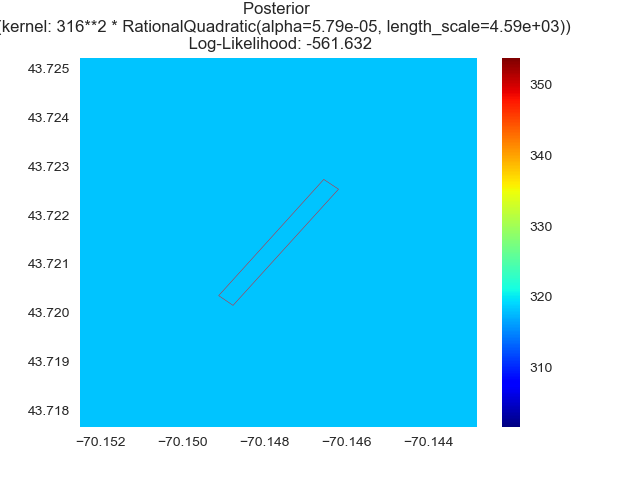

In [31]:
extent = [boundary[3], boundary[2], boundary[1], boundary[0]]
vmin = df['sw pCO2 (uatm)'].min()
vmax = df['sw pCO2 (uatm)'].max()

fig, ax = plt.subplots()
im = ax.imshow(data_arr[:, :, 4], cmap='jet', origin='lower', 
               interpolation='gaussian', extent=extent, aspect='auto',
               vmin=vmin, vmax=vmax)
ax.grid(False)

# adds the location of the farm
ax.add_patch(patches.Polygon(xy=corners, fill=False, edgecolor='r'))
ax.set_title("Posterior \n: (kernel: %s)\n Log-Likelihood: %.3f" % (gpr.kernel_, gpr.log_marginal_likelihood(gpr.kernel_.theta)))
cbar = fig.colorbar(im, format='%1.0f')

### possible mistakes:

Fix alpha levels, maybe too much noise?
normalize time / binning time. maybe the time at in times[] have too much influence?
How can I debug this / find examples of functions that I know and debug

why / how sure are we that pco2 is the variable to concentrate on

<IPython.core.display.Javascript object>


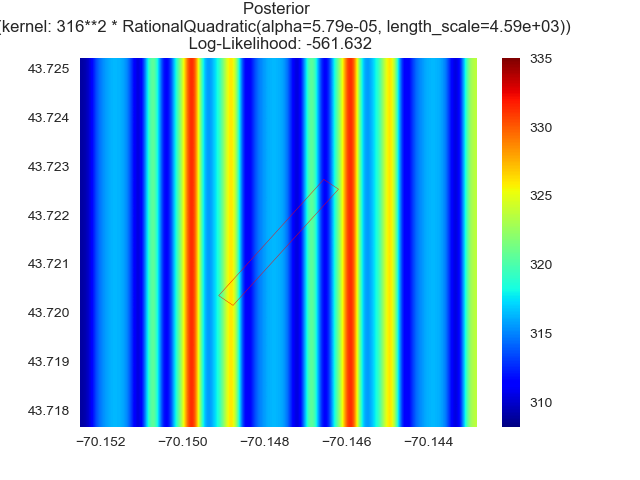

In [47]:
extent = [boundary[3], boundary[2], boundary[1], boundary[0]]

plt.figure()
im = plt.imshow(data_arr.reshape(time_size, heatmap_size, heatmap_size)[:, 1, :], cmap='jet', origin='lower', interpolation='gaussian', extent=extent, aspect='auto')
plt.grid(False)

# adds the location of the farm
plt.gca().add_patch(patches.Polygon(xy=corners, fill=False, edgecolor='r'))
plt.title("Posterior \n: (kernel: %s)\n Log-Likelihood: %.3f" % (gpr.kernel_, gpr.log_marginal_likelihood(gpr.kernel_.theta)))
plt.colorbar()

In [42]:
pd.DataFrame(data_arr.reshape(time_size, heatmap_size, heatmap_size)[0, :, :])

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,308.643427,320.936463,335.060222,313.687985,318.306591,329.159242,308.907196,315.119260,316.574097,316.130451,...,316.574097,316.130451,308.185856,323.981290,308.643427,320.936463,335.060222,313.687985,318.306591,329.159242
1,308.907196,315.119260,316.574097,316.130451,308.185856,323.981290,308.643427,320.936463,335.060222,313.687985,...,335.060222,313.687985,318.306591,329.159242,308.907196,315.119260,316.574097,316.130451,308.185856,323.981290
2,308.643427,320.936463,335.060222,313.687985,318.306591,329.159242,308.907196,315.119260,316.574097,316.130451,...,316.574097,316.130451,308.185856,323.981290,308.643427,320.936463,335.060222,313.687985,318.306591,329.159242
3,308.907196,315.119260,316.574097,316.130451,308.185856,323.981290,308.643427,320.936463,335.060222,313.687985,...,335.060222,313.687985,318.306591,329.159242,308.907196,315.119260,316.574097,316.130451,308.185856,323.981290
4,308.643427,320.936463,335.060222,313.687985,318.306591,329.159242,308.907196,315.119260,316.574097,316.130451,...,316.574097,316.130451,308.185856,323.981290,308.643427,320.936463,335.060222,313.687985,318.306591,329.159242
5,308.907196,315.119260,316.574097,316.130451,308.185856,323.981290,308.643427,320.936463,335.060222,313.687985,...,335.060222,313.687985,318.306591,329.159242,308.907196,315.119260,316.574097,316.130451,308.185856,323.981290
6,308.643427,320.936463,335.060222,313.687985,318.306591,329.159242,308.907196,315.119260,316.574097,316.130451,...,316.574097,316.130451,308.185856,323.981290,308.643427,320.936463,335.060222,313.687985,318.306591,329.159242
7,308.907196,315.119260,316.574097,316.130451,308.185856,323.981290,308.643427,320.936463,335.060222,313.687985,...,335.060222,313.687985,318.306591,329.159242,308.907196,315.119260,316.574097,316.130451,308.185856,323.981290
8,308.643427,320.936463,335.060222,313.687985,318.306591,329.159242,308.907196,315.119260,316.574097,316.130451,...,316.574097,316.130451,308.185856,323.981290,308.643427,320.936463,335.060222,313.687985,318.306591,329.159242
9,308.907196,315.119260,316.574097,316.130451,308.185856,323.981290,308.643427,320.936463,335.060222,313.687985,...,335.060222,313.687985,318.306591,329.159242,308.907196,315.119260,316.574097,316.130451,308.185856,323.981290


In [34]:
data_arr.shape

(30, 30, 12)

In [195]:
df2 = pd.read_csv('FLO_L3_20170317.csv', skiprows=[1])

# filters out all the values that are -9999
df2.replace(-9999, np.NaN, inplace=True)
df2 = df[['Lat', 'Lon', 'secDay', 'Water temp (C)', 'Salinity (PSU)', 'O2 umol/L', 'Chl a (mg/m3)', 'sw pCO2 (uatm)']]
df2.dropna(inplace=True)

NW = (-70.14655, 43.72273)
NE = (-70.14619, 43.72253)
SE = (-70.14876, 43.72015)
SW = (-70.14911, 43.72035)
corners = [NW, NE, SE, SW]

In [ ]:
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=1e-4, normalize_y=True)

In [ ]:
extent = [boundary[3], boundary[2], boundary[1], boundary[0]]

fig, ax = plt.subplots()
im = ax.imshow(data_arr, cmap='jet', origin='lower', interpolation='gaussian', extent=extent, aspect='auto')
ax.grid(False)

# adds the location of the farm
ax.add_patch(patches.Polygon(xy=corners, fill=False, edgecolor='r'))
ax.set_title("Posterior \n: (kernel: %s)\n Log-Likelihood: %.3f" % (gpr.kernel_, gpr.log_marginal_likelihood(gpr.kernel_.theta)))
fig.colorbar(im)